# Test inference on ESP32 microcontroller

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import serial
from serial import Serial
import time

import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

In [28]:
try:
  %tensorflow_version 2.x
except:
  pass

In [29]:
INPUT_IMAGE_SIZE = 28

# Path to TensorFlow Lite model file
tflite_model_file = 'models/mnist_quant.tflite'

# Path to images folder
path = 'test_images_14x14/'
file_format = ".jpg"



EXPECTED_PRECISION = 0.000001

In [30]:
# Function to open serial port
def init_serial(port_name):
    # Configure and open serial port
    port = serial.Serial(
        port=port_name,
        baudrate=115200,
        bytesize=serial.EIGHTBITS,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        xonxoff=False,
        rtscts=False,
        dsrdtr=False
    )
    
    port.reset_input_buffer()
    port.reset_output_buffer()
    return port

In [31]:
def send_to_mcu(port, data):
    bytes_written = port.write(data)
    return bytes_written

In [32]:
def read_result_from_mcu(port):
    line = port.read_until()   # read a '\n' terminated line
    return line

In [33]:
def infer_with_TF_lite(interpreter, input_details, output_details, raw_image):
    # Get input size
    img = raw_image

    # Normalize image
    #img = img / 255.
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    # Add a batch dimension and a dimension because we use grayscale format
    # Reshape from (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE) to (1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, 1)
    test_image=raw_image
    #print('Data Type ',test_image.dtype)
    
    input_scale, input_zero_point = input_details["quantization"]
    test_image = test_image / input_scale + input_zero_point
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    # Point the data to be used for testing
    interpreter.set_tensor(input_details['index'], test_image)

    # Run the interpreter
    interpreter.invoke()

    # Obtain results
    #predictions = interpreter.get_tensor(output_details['index'])[0]
    output = interpreter.get_tensor(output_details['index'])[0]
    predictions = output.argmax()
    
    return predictions

In [34]:
def infer_with_MCU(raw_image):
    img = np.array(raw_image, dtype=np.uint8)
    bytes_sent = send_to_mcu(serial_port, img)
    
    response_str = read_result_from_mcu(serial_port)
    response_str = response_str.decode("utf-8")
    print(response_str)
    predictions = np.fromstring(response_str, dtype=np.float32, sep=',')
    predictions = predictions.argmax()
    return predictions

In [35]:
def compare_results(result_tfl, result_mcu):
    for i in range(len(result_tfl)):
        if abs(result_tfl[i] - result_mcu[i]) > EXPECTED_PRECISION :
            return False
        else:
            pass
    return True

In [36]:
# Create Interpreter (Load TFLite model).
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
# Allocate tensors
interpreter.allocate_tensors()

In [37]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### Be sure your ESP32 board connected to development computer.

In [38]:
# Get list of present serial ports
!dmesg | grep -e tty

[    0.097577] printk: console [tty0] enabled
[  899.770194] usb 1-3: cp210x converter now attached to ttyUSB0
[  939.265644] cp210x ttyUSB0: failed set request 0x7 status: -19
[  939.265653] cp210x ttyUSB0: failed set request 0x12 status: -19
[  939.265658] cp210x ttyUSB0: failed set request 0x0 status: -19
[  939.265923] cp210x ttyUSB0: cp210x converter now disconnected from ttyUSB0
[  942.303292] usb 1-3: cp210x converter now attached to ttyUSB0


In [39]:
# Configure and open serial port
SERIAL_PORT_NAME = '/dev/ttyUSB0'
serial_port = init_serial(SERIAL_PORT_NAME)

# Check which port was really used
print("Opened serial port : {0}".format(serial_port.name))        

Opened serial port : /dev/ttyUSB0


In [40]:
files = [files for files in glob.glob(path + "*" + file_format, recursive=False)]
print("Found {0} {1} files".format(len(files), file_format))

Found 0 .jpg files


### Run inference on TensorFlow Lite model and on MCU. Compare results.

-1.105287e+01,-1.354208e+01,-3.621679e+00,1.183993e+00,-3.911577e-01,-9.724754e-02,-7.188730e+00,1.805462e+00,-2.511660e-01,6.759808e+00,


Result_tfl =  1
Result_mcu = 9
Run time: 1.08544 seconds



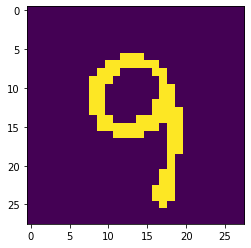

In [43]:
# Test on random mnist database numbers
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Filter intermediate values to scale for use in uC
train_images[train_images>200]=255
train_images[train_images<=200]=0

test_images[test_images>200]=255
test_images[test_images<=200]=0


for f in range(1):
    
    # load random mnist number
    index = np.random.randint(0,59999)
    
    # Read image
    raw_image = train_images[index]
    plt.imshow(raw_image)
    
    #result_tfl = infer_with_TF_lite(interpreter, input_details, output_details, raw_image)
    
    start_time = time.time(); 
    result_mcu = infer_with_MCU(raw_image)
    end_time = time.time(); 

    #status = compare_results(result_tfl, result_mcu)
    #status_str = "Ok" if status else "Reults NOT eqal!"
    #print("For file: {0} - {1}".format(f, status_str))
    print("\nResult_tfl = ", result_tfl)
    print("Result_mcu =", result_mcu)
    print("Run time: %.5f seconds\n" %(end_time-start_time))

In [25]:
raw_image.dtype

dtype('uint8')

In [26]:
serial_port.close()